In [1]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot
import seaborn as sbn
import seaborn as sbn
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier

In [2]:
pd. set_option("display.max_columns", None) 

In [3]:
df = pd.read_csv('./ios-fitness-and-medical-cleaned-data.csv')

#### Feature Engineering

In [4]:
def is_english_supported(language):
    return language.find('English') >=0

In [5]:
def determine_if_app_is_free_or_not(price):
    if (price > 0):
        return 'PAID'
    return 'FREE'

In [6]:
def grade_app_with_rating(app_rating):
    if ((app_rating >=0) and (app_rating <2.5)):
        return 'BAD'
    if ((app_rating >=2.5) and (app_rating <3.0)):
        return 'FAIR'
    if ((app_rating >=3.0) and (app_rating <4.0)):
        return 'GOOD'
    if ((app_rating >=4.0) and (app_rating <4.5)):
        return 'VERY GOOD'
    if (app_rating >=4.5):
        return 'EXCELLENT'

- 1-49 : FAIR
- 50 - 99 : GOOD
- 100 - 500 : VERY GOOD
- 501+ : EXCELLENT

In [7]:
def grade_app_with_rating2(app_rating, rating_count):
    if ((app_rating >=0) and (app_rating <2.5)):
        return 'BAD'
    if ((app_rating >=2.5) and (app_rating <3.0)):
        return 'FAIR'
    if ((app_rating >=3.0) and (app_rating <4.0)):
        if rating_count < 50:
            return 'FAIR'
        return 'GOOD'
    if ((app_rating >=4.0) and (app_rating <4.5)):
        if rating_count < 50:
            return 'FAIR'
        elif rating_count >=50 and rating_count <100:
            return 'GOOD' 
        else:
            return 'VERY GOOD'
    if (app_rating >=4.5):
        if rating_count < 50:
            return 'FAIR'
        elif rating_count >=50 and rating_count <100:
            return 'GOOD'
        elif rating_count >=100 and rating_count < 500:
            return 'VERY GOOD'
        else:
            return 'EXCELLENT'

In [8]:
def create_rating_count_range(rating_count):
    if (rating_count >=1 and rating_count<5):
        return '1+'
    if (rating_count >=5 and rating_count<10):
        return '5+'
    if (rating_count >=10 and rating_count<50):
        return '10+'
    if (rating_count >=50 and rating_count<100):
        return '50+'
    if (rating_count >=100 and rating_count<500):
        return '100+'
    if (rating_count >=500 and rating_count<1000):
        return '500+'
    if (rating_count >=1000 and rating_count<5000):
        return '1,000+'
    if (rating_count >=5000 and rating_count<10000):
        return '5,000+'
    if (rating_count >=10000 and rating_count<50000):
        return '10,000+'
    if (rating_count >=50000 and rating_count<100000):
        return '50,000+'
    if (rating_count >=100000 and rating_count<500000):
        return '100,000+'
    if (rating_count >=500000 and rating_count<1000000):
        return '500,000+'
    if (rating_count >=1000000 and rating_count<5000000):
        return '1,000,000+'
    if (rating_count >=5000000 and rating_count<10000000):
        return '5,000,000+'
    if (rating_count >=10000000 and rating_count<50000000):
        return '10,000,000+'
    if (rating_count >=50000000 and rating_count<100000000):
        return '50,000,000+'
    return 0

In [9]:
def create_price_category(rating_count):
    if (rating_count >0.0 and rating_count<1.0):
        return '0+'
    if (rating_count >=1 and rating_count<5):
        return '1+'
    if (rating_count >=5 and rating_count<10):
        return '5+'
    if (rating_count >=10 and rating_count<50):
        return '10+'
    if (rating_count >=50 and rating_count<100):
        return '50+'
    if (rating_count >=100 and rating_count<500):
        return '100+'
    if (rating_count >=500 and rating_count<1000):
        return '500+'
    return None

In [10]:
def is_app_available_in_multiple_languages(languages):
    return len(languages.split(',')) > 1

In [11]:
def is_privacy_data_collected(privacy_data):
    if pd.notna(privacy_data):
        return True
    return False

In [12]:
def is_app_ever_updated(version_count):
    return version_count > 1

In [13]:
def is_app_updated_in_2022(last_updated_date, released_date, versions_count):
    if (versions_count < 2):
        return False
    if (last_updated_date == released_date):
        return False
    if '2022' in last_updated_date:
        return True
    return False

In [14]:
def perform_feature_engineering(df):
    lang_na_indexes = df[df['Languages'].isna()].index
    df.loc[lang_na_indexes, 'Languages'] = 'Not Specified'
    df['is_english_supported'] = df['Languages'].apply(is_english_supported)
    df['Download Type'] = df['Price'].apply(determine_if_app_is_free_or_not)
#     df['App Grade'] = df['Average Rating'].apply(grade_app_with_rating)
    df['Rating Count Range'] = df['Rating Count'].apply(create_rating_count_range)
    df['is_available_in_multiple_langs'] = df['Languages'].apply(is_app_available_in_multiple_languages)
    df['is_privacy_data_collected'] = df['Privacy Data'].apply(is_privacy_data_collected)
    df['is_app_ever_updated'] = df['Number of Versions'].apply(is_app_ever_updated)
    df['Price Category'] = df['Price'].apply(create_price_category)
    for index in df.index:
        last_updated_date = df.at[index, 'Last Version Date']
        released_date = df.at[index, 'First Version Date']
        version = df.at[index, 'Number of Versions']
        rating_count = df.at[index, 'Rating Count']
        average_rating = df.at[index, 'Average Rating']
        df.at[index, 'is_updated_this_year'] = is_app_updated_in_2022(last_updated_date, released_date, version)
        df.at[index, 'App Grade'] = grade_app_with_rating2(average_rating, rating_count)

In [15]:
perform_feature_engineering(df)

#### VISUALIZATION

In [16]:
rating_count_range_order = [0, '1+', '5+', '10+', '50+', '100+', '500+', '1,000+', '5,000+', '10,000+', '50,000+', 
                            '100,000+', '500,000+', '1,000,000+']

In [17]:
price_range_order = ['0+', '1+', '5+', '10+', '50+', '100+', '500+']

In [18]:
app_grade_order = ['BAD', 'FAIR', 'GOOD', 'VERY GOOD', 'EXCELLENT']

In [19]:
def draw_histogram(data, x_axis_title, height=5, aspect=1.6):
    sbn.displot(data, color = 'darkblue', kind='hist', height=5, aspect=1.6)
    pyplot.xlabel(x_axis_title)
    pyplot.ylabel('Density')

In [20]:
def draw_count_plot(data, x_column, x_label, y_label, fig_size=(8,6), order=None, hue=None):
    sbn.set(rc = {'figure.figsize':fig_size})
    sbn.countplot(data=data, x=x_column, order=order, color='#1C8BAD', hue=hue )
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='large')
    pyplot.show()

In [21]:
def draw_count_plot_with_annot(data, x_column, x_label, y_label, fig_size=(8,6),annotCount=False, order=None, 
                               hue=None, palette=None):
    sbn.set(rc = {'figure.figsize':fig_size})
    sbndataplot = sbn.countplot(data=data, x=x_column, order=order, color='#1C8BAD', hue=hue, palette=palette)
    for p in sbndataplot.patches:
        if annotCount == True:
            height = p.get_height()
            if (pd.isna(height) == True):
                height = 0
            else:
                height = int(height)
            sbndataplot.annotate(height, 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
        else:
            sbndataplot.annotate(format(p.get_height()/len(data)*100, '.2f')+'%', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='large')
    pyplot.tight_layout(rect=(0, 0, 1, 1.4))
    pyplot.show()

In [22]:
def set_plot_labels(x_label, y_label, font_size):
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize=font_size)

#### Price influence

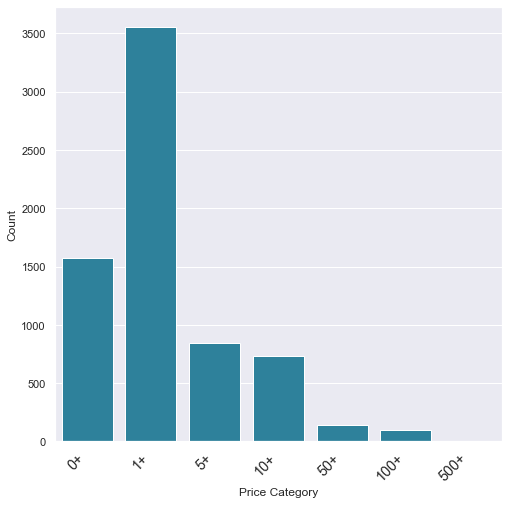

In [23]:
draw_count_plot(df, 'Price Category', 'Price Category', 'Count', fig_size=(8,8), 
               order=price_range_order)

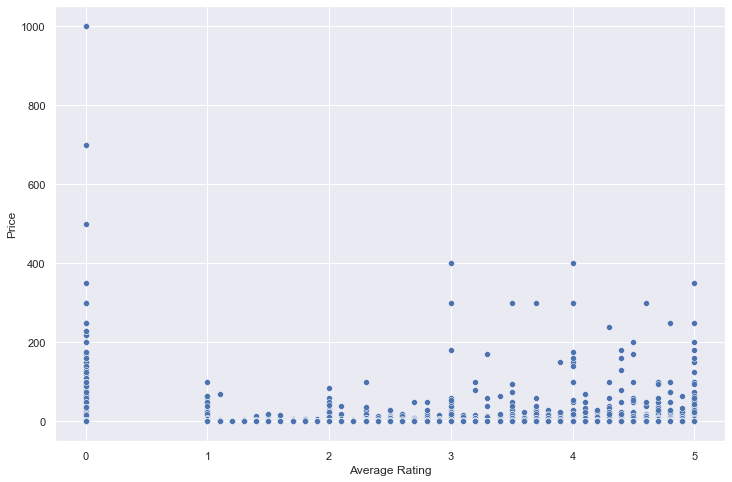

In [24]:
sbn.scatterplot(data=df, y='Price', x='Average Rating')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

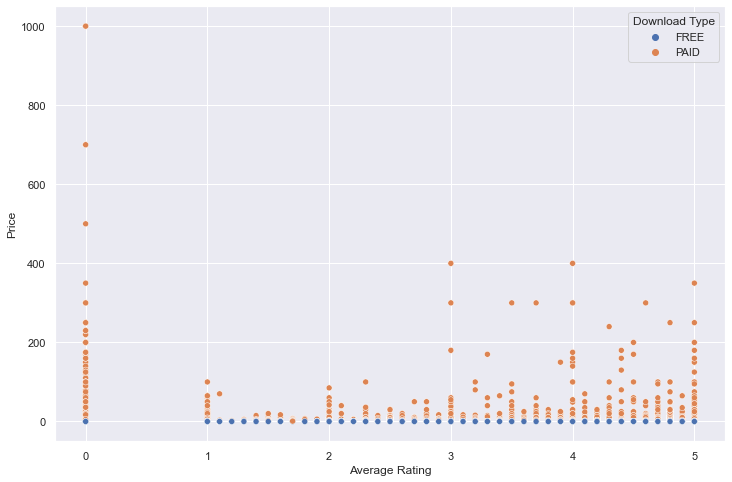

In [25]:
sbn.scatterplot(data=df, y='Price', x='Average Rating', hue='Download Type', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

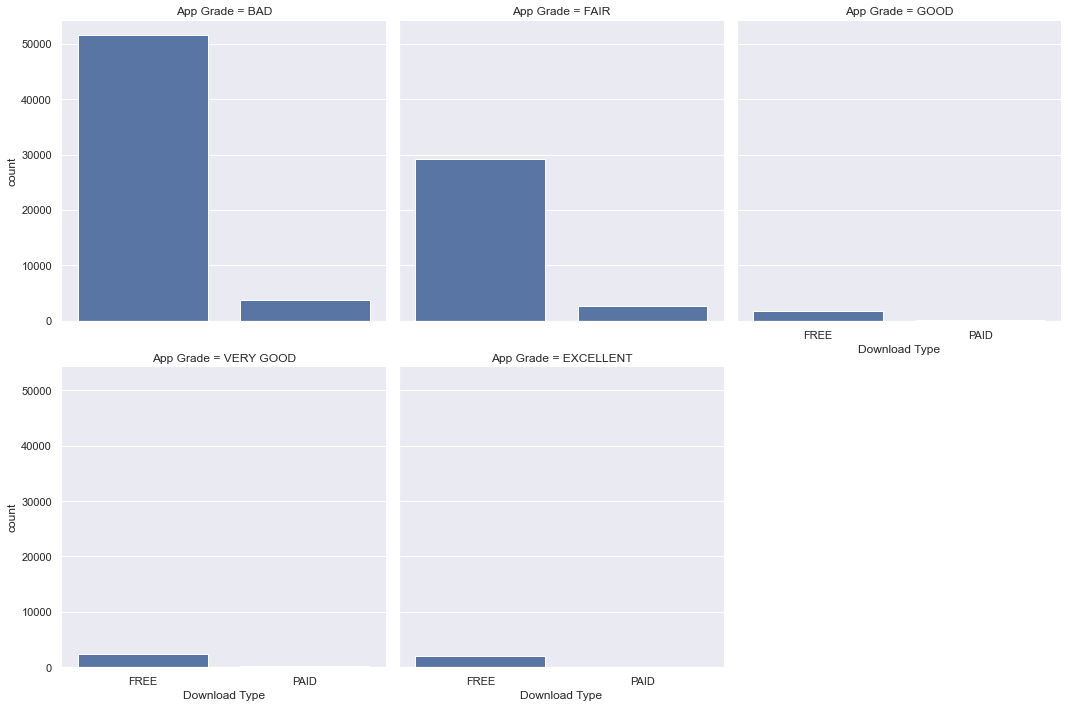

In [26]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=3, height=5, aspect=1.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Download Type", order=['FREE', 'PAID'])

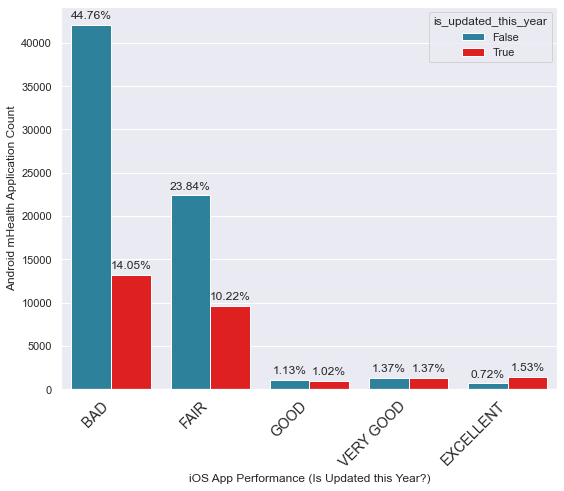

In [27]:
draw_count_plot_with_annot(df, 'App Grade', 'iOS App Performance (Is Updated this Year?)',
                           'Android mHealth Application Count',hue= 'is_updated_this_year', fig_size=(8,5),
                           order=app_grade_order,
                           annotCount=False, palette=['#1C8BAD', 'red'])

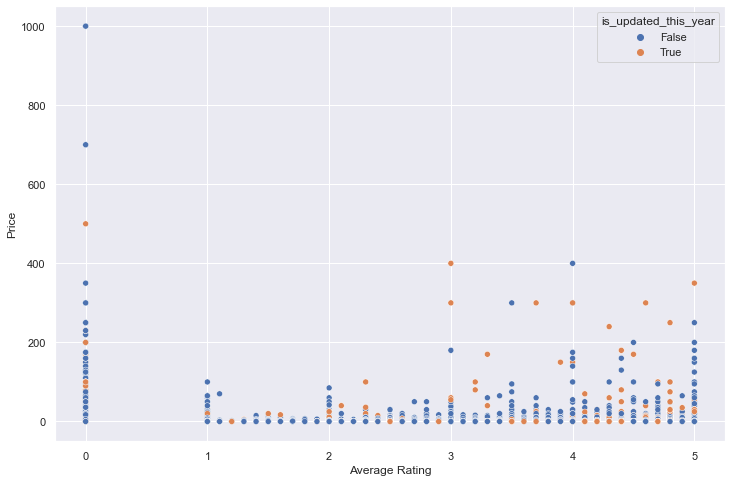

In [28]:
sbn.scatterplot(data=df, x='Average Rating', y='Price', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


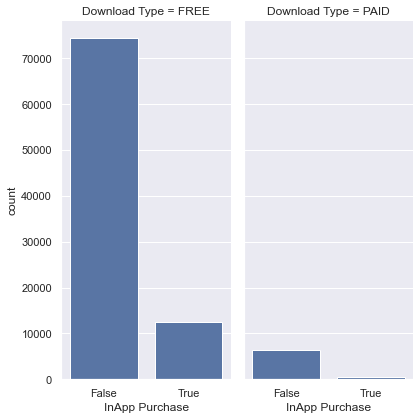

In [29]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Download Type", col_wrap=2, height=6, aspect=0.5)
eng_supp_app_grade_plot.map(sbn.countplot, "InApp Purchase")

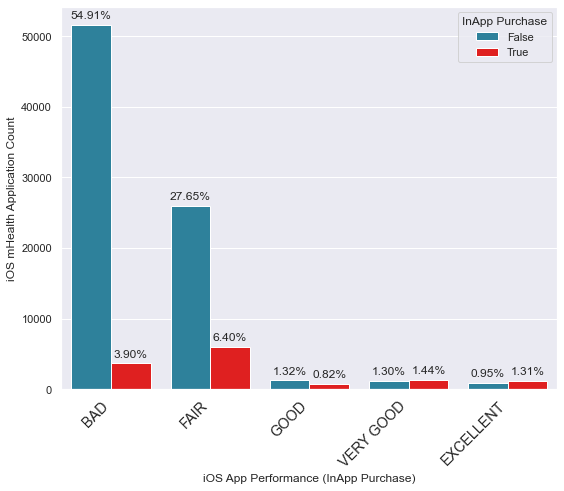

In [30]:
draw_count_plot_with_annot(df, 'App Grade', 'iOS App Performance (InApp Purchase)',
                           'iOS mHealth Application Count',hue= 'InApp Purchase', fig_size=(8,5),
                           order=app_grade_order,
                           annotCount=False, palette=['#1C8BAD', 'red'])

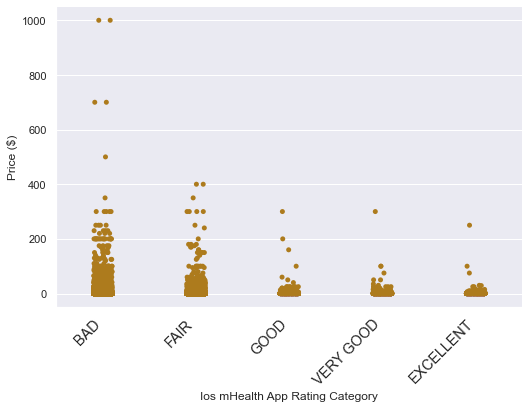

In [31]:
sbn.catplot(data=df, x='App Grade', y='Price',
            height=5, aspect=1.5, color="#AD7B1D", order=app_grade_order)
set_plot_labels('Ios mHealth App Rating Category', 'Price ($)', 'large')

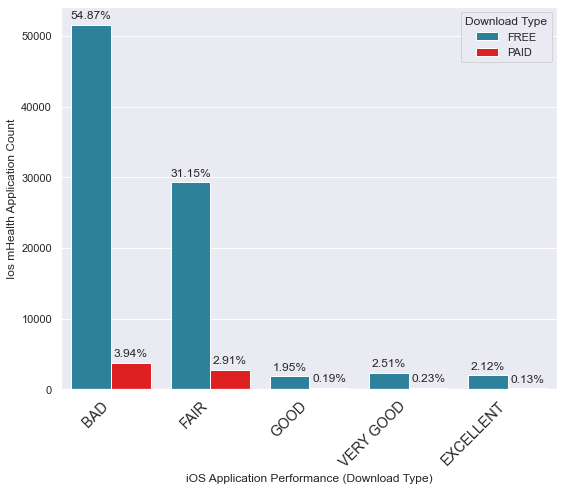

In [32]:
draw_count_plot_with_annot(df, 'App Grade', 'iOS Application Performance (Download Type)',
                           'Ios mHealth Application Count',hue= 'Download Type', fig_size=(8,5), 
                           order=app_grade_order,
                           annotCount=False, palette=['#1C8BAD', 'red'])

#### Application Rating effect on the app?

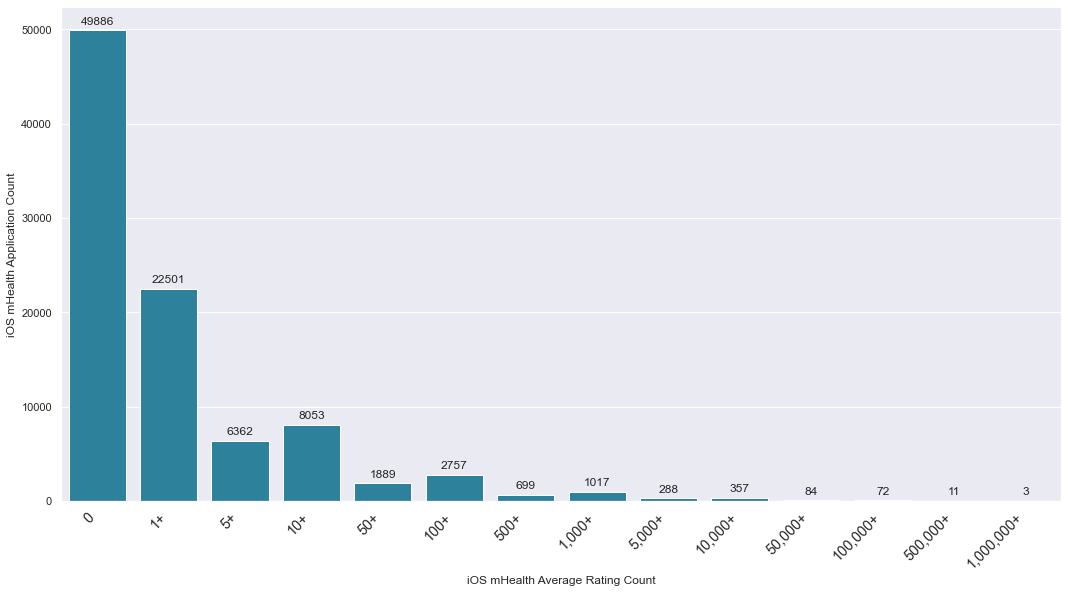

In [33]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'iOS mHealth Average Rating Count', 
                           'iOS mHealth Application Count',fig_size=(15,6), annotCount=True,
                           order=rating_count_range_order)

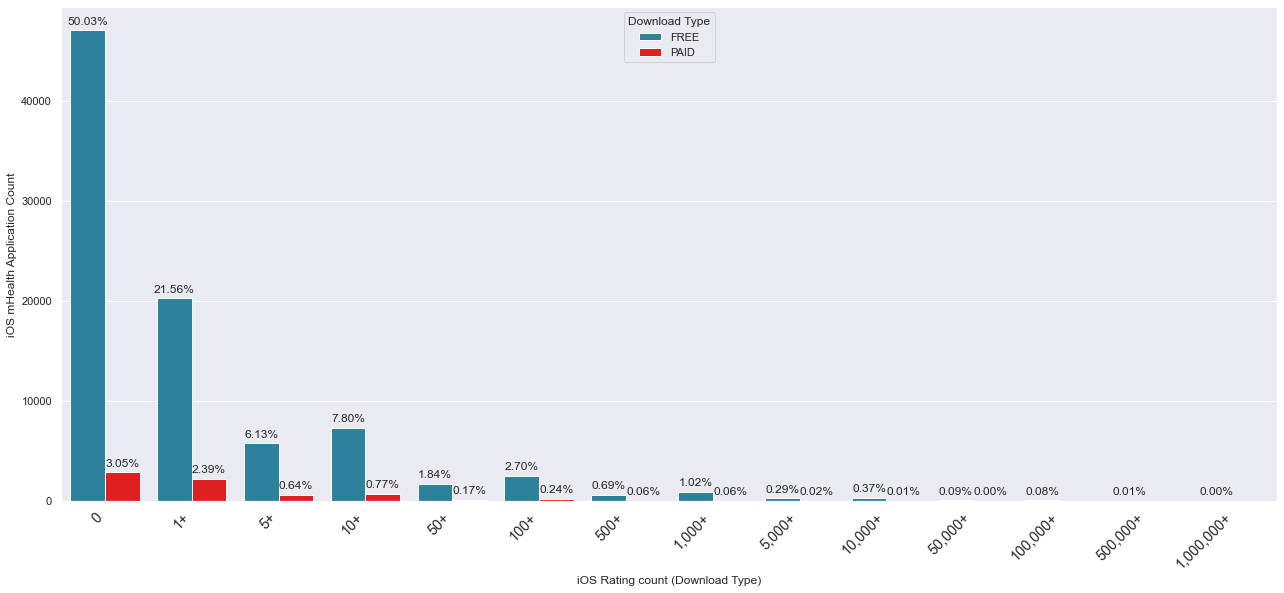

In [34]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'iOS Rating count (Download Type)',
                           'iOS mHealth Application Count',hue= 'Download Type', fig_size=(18,6),
     order=rating_count_range_order, annotCount=False, palette=['#1C8BAD', 'red'])

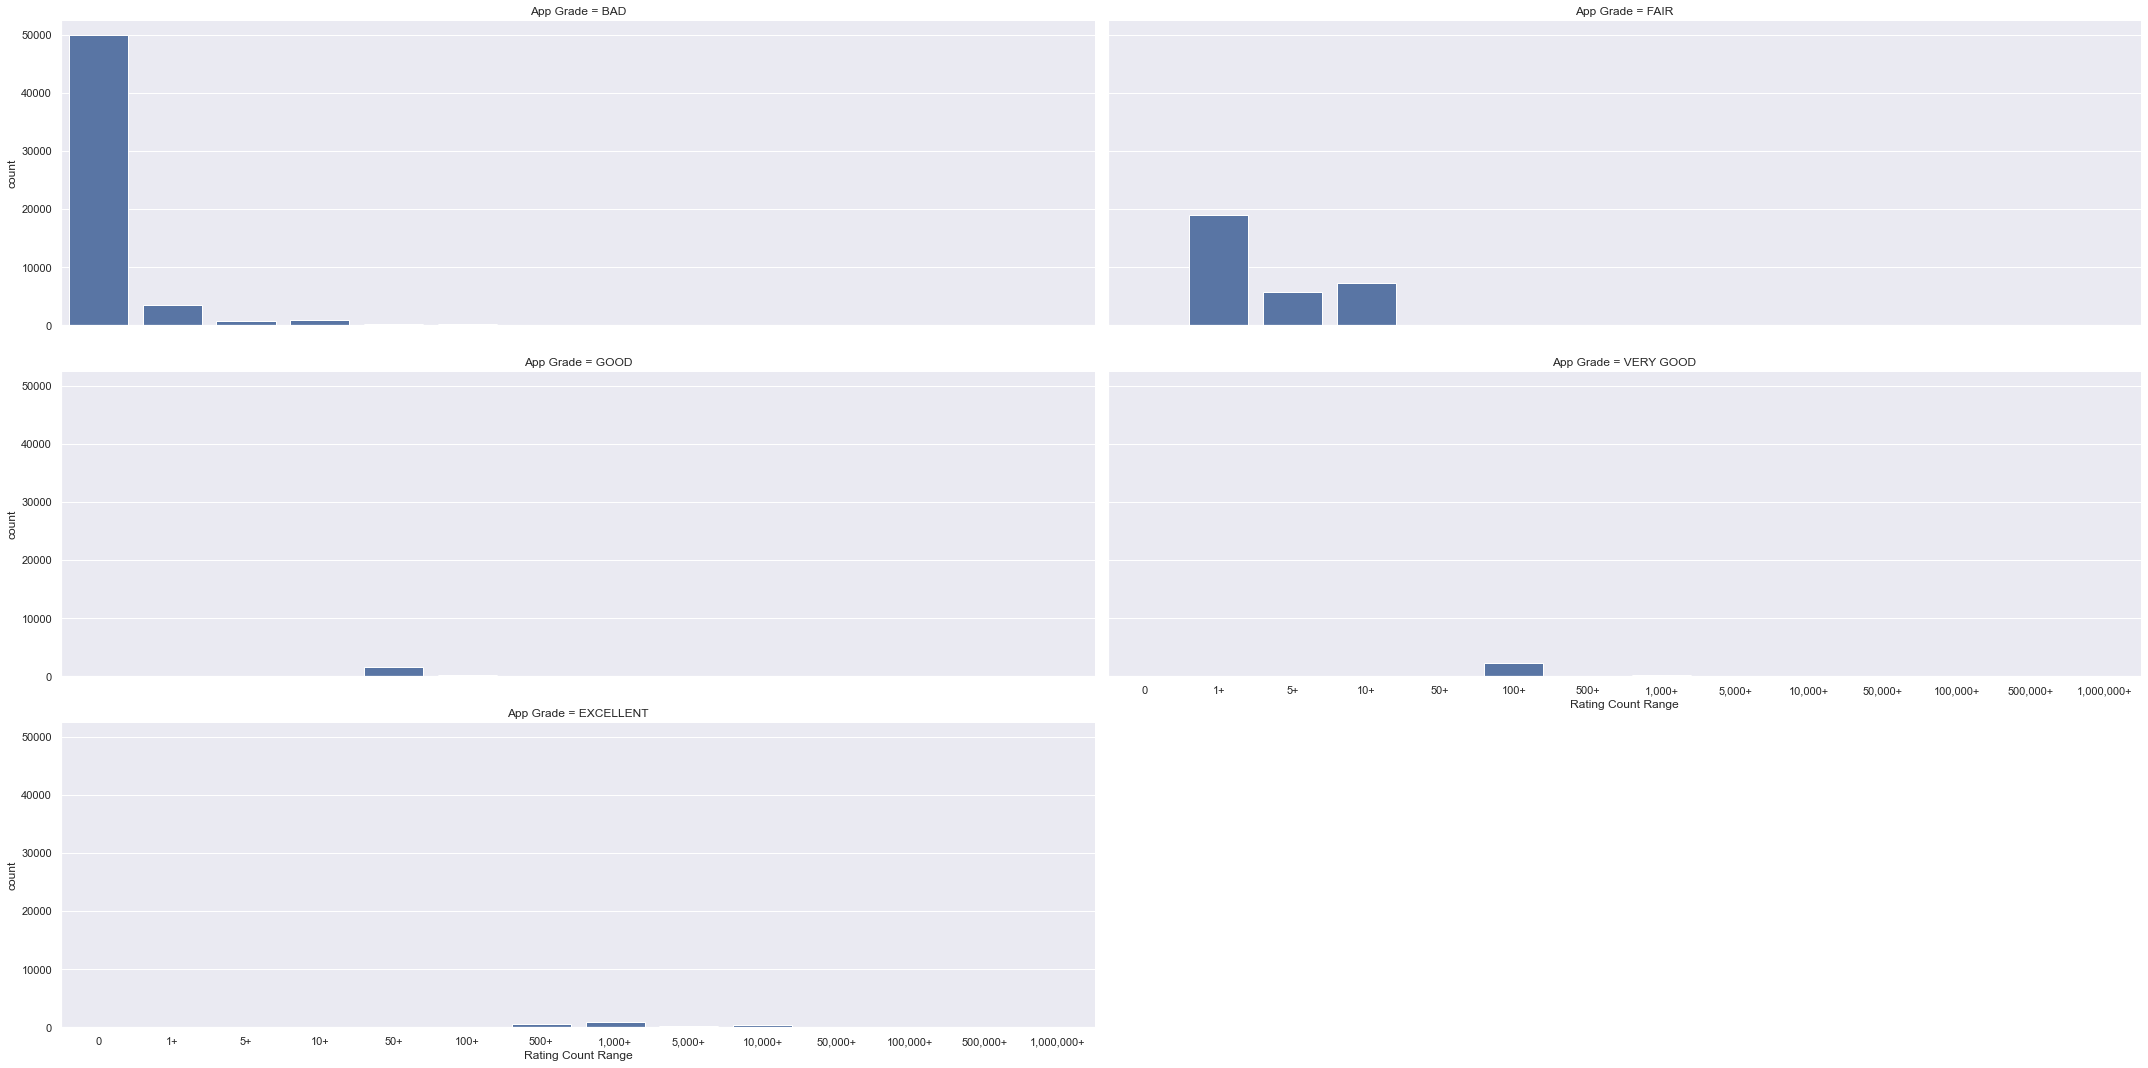

In [35]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=2, height=5, aspect=3.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

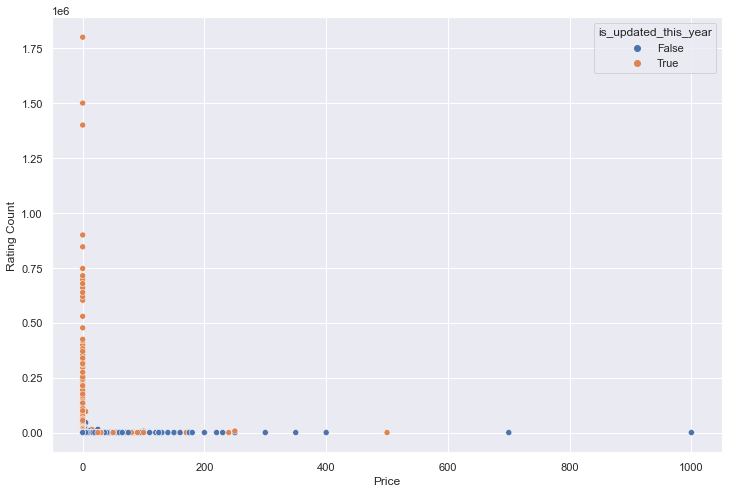

In [36]:
sbn.scatterplot(data=df, y='Rating Count', x='Price', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

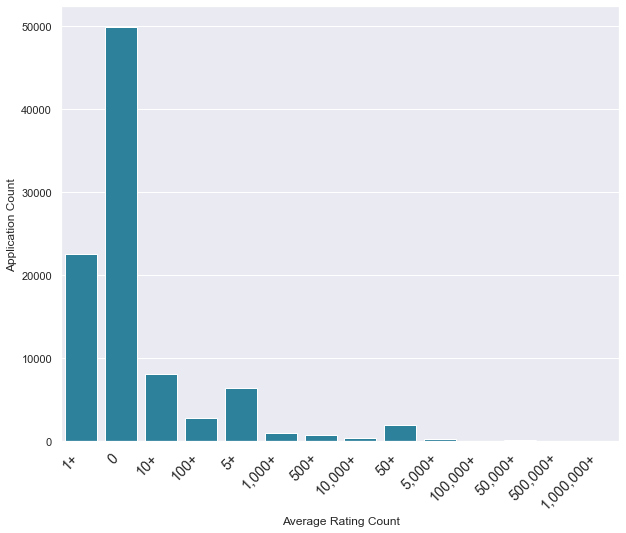

In [37]:
draw_count_plot(df, 'Rating Count Range', 'Average Rating Count', 'Application Count', fig_size=(10,8))

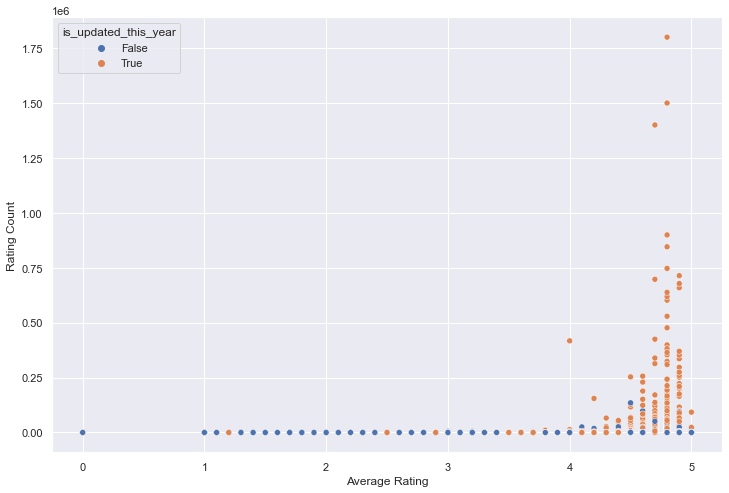

In [38]:
sbn.scatterplot(data=df, y='Rating Count', x='Average Rating', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

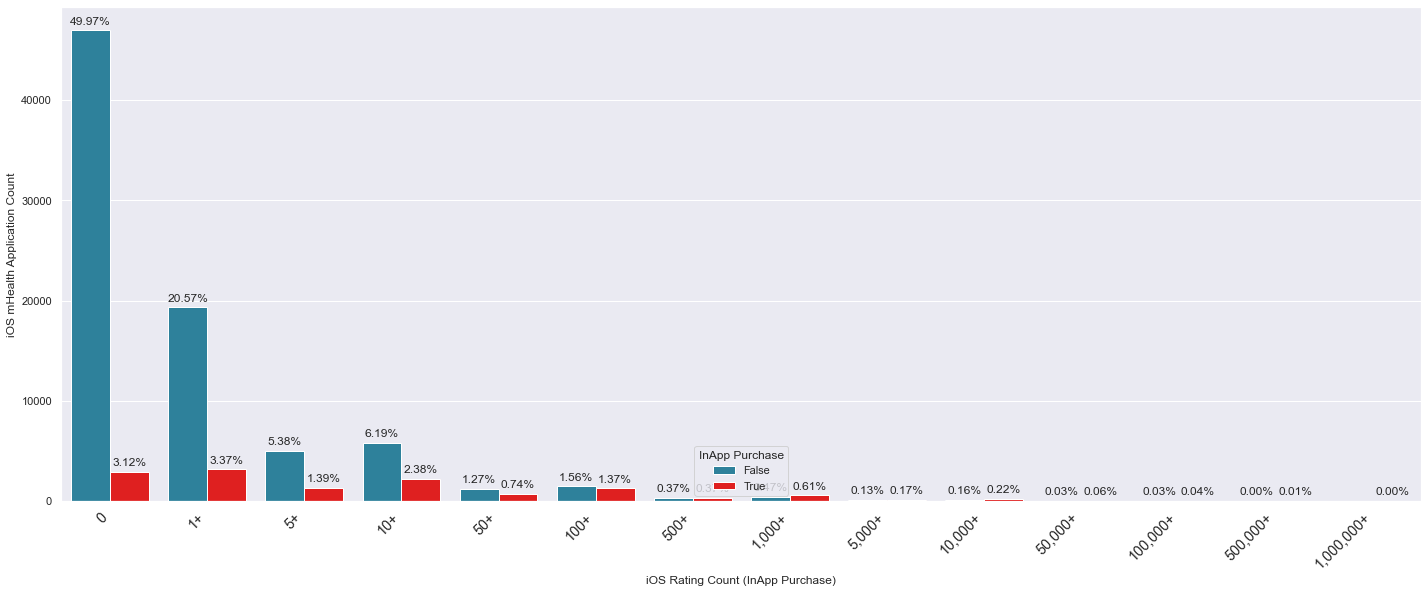

In [39]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'iOS Rating Count (InApp Purchase)',
                           'iOS mHealth Application Count',hue= 'InApp Purchase', fig_size=(20,6), 
     order=rating_count_range_order, annotCount=False, palette=['#1C8BAD', 'red'])

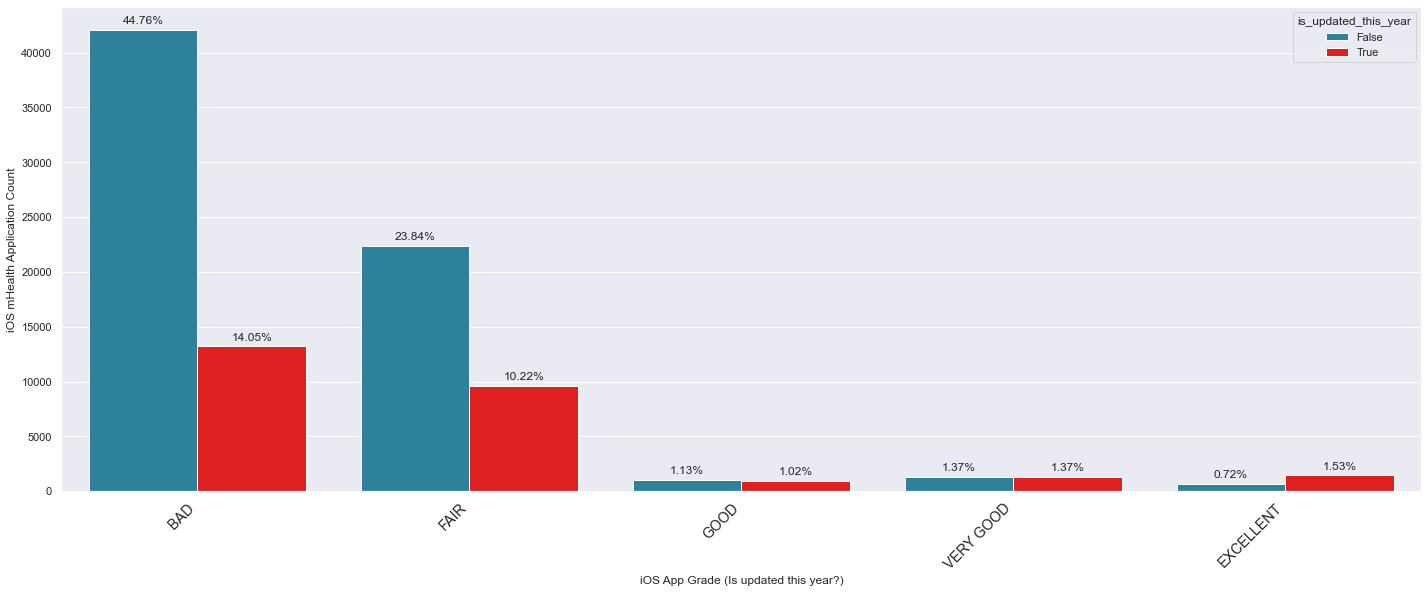

In [40]:
draw_count_plot_with_annot(df, 'App Grade', 'iOS App Grade (Is updated this year?)',
                           'iOS mHealth Application Count',hue= 'is_updated_this_year', fig_size=(20,6), 
     order=app_grade_order, annotCount=False, palette=['#1C8BAD', 'red'])

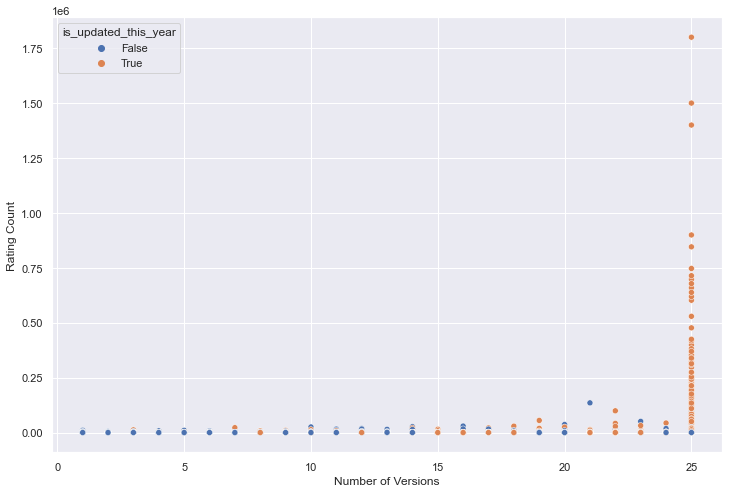

In [41]:
sbn.scatterplot(data=df, y='Rating Count', x='Number of Versions', hue='is_updated_this_year',
                legend='brief', color="#0a4020", palette="deep")
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

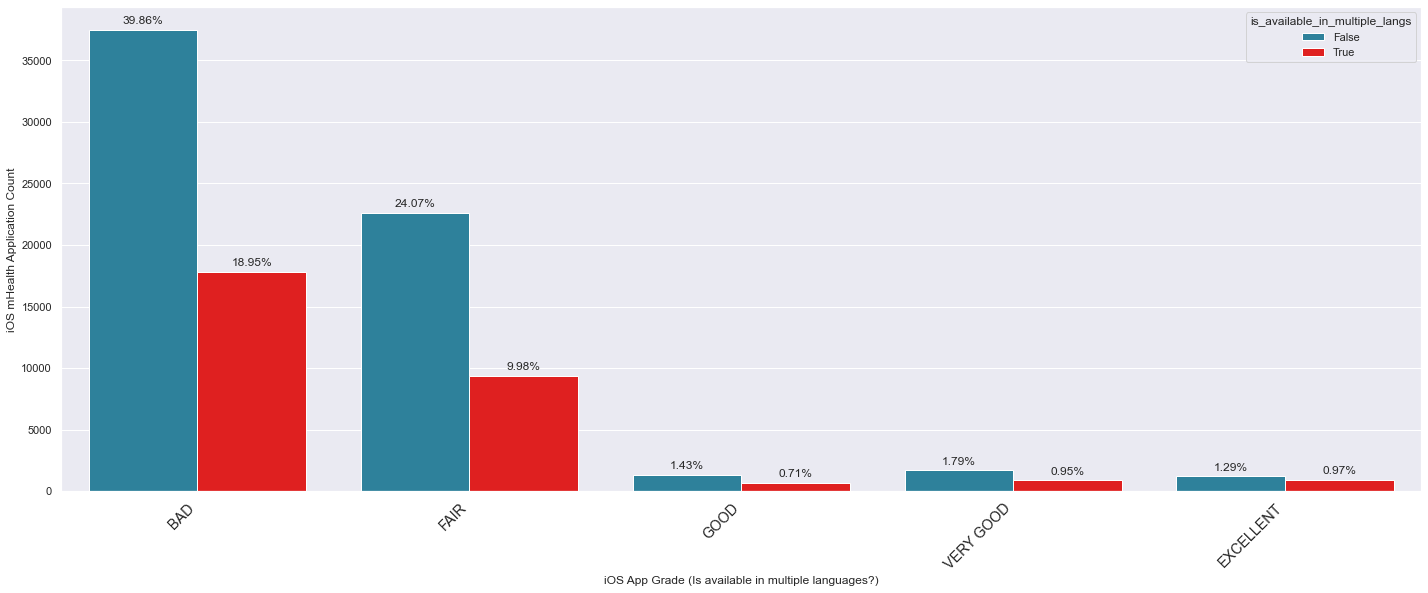

In [42]:
draw_count_plot_with_annot(df, 'App Grade', 'iOS App Grade (Is available in multiple languages?)',
                           'iOS mHealth Application Count',hue= 'is_available_in_multiple_langs', fig_size=(20,6), 
     order=app_grade_order, annotCount=False, palette=['#1C8BAD', 'red'])

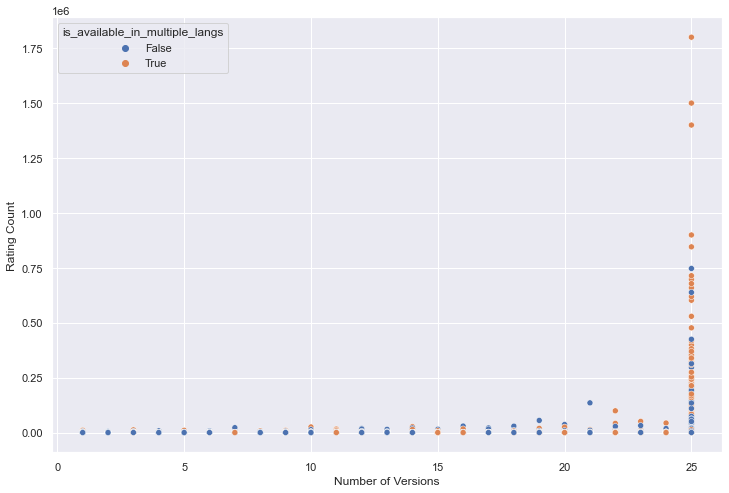

In [43]:
sbn.scatterplot(data=df, y='Rating Count', x='Number of Versions', hue='is_available_in_multiple_langs',
                legend='brief', color="#0a4020", palette="deep")
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

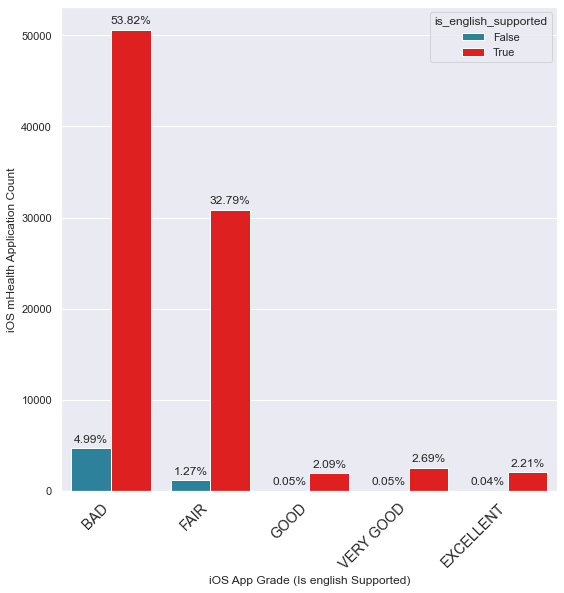

In [44]:
draw_count_plot_with_annot(df, 'App Grade', 'iOS App Grade (Is english Supported)',
                           'iOS mHealth Application Count',hue= 'is_english_supported', fig_size=(8,6), 
     order=app_grade_order, annotCount=False, palette=['#1C8BAD', 'red'])

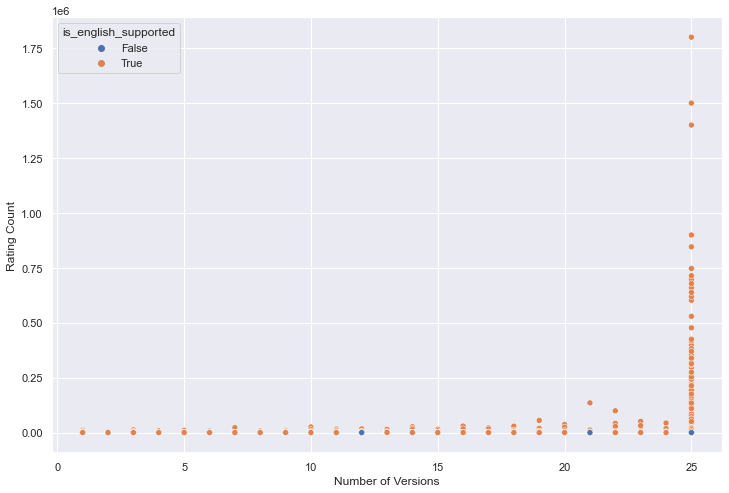

In [45]:
sbn.scatterplot(data=df, y='Rating Count', x='Number of Versions', hue='is_english_supported',
                legend='brief', color="#0a4020", palette="deep")
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

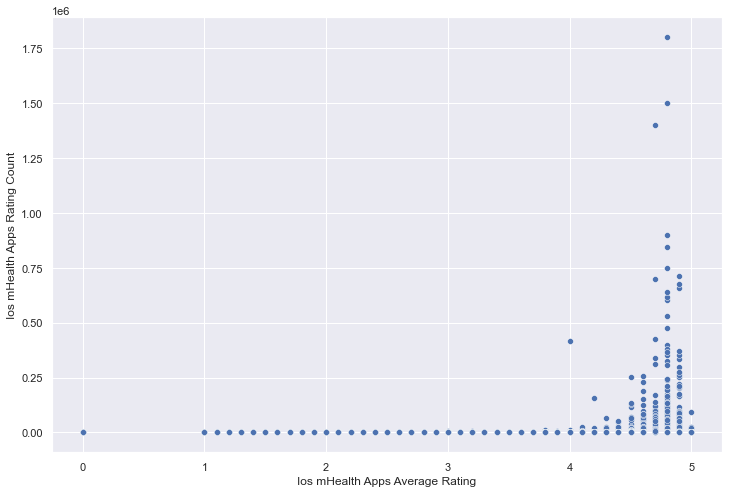

In [46]:
sbn.scatterplot(data=df, y='Rating Count', x='Average Rating')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)
pyplot.xlabel('Ios mHealth Apps Average Rating')
pyplot.ylabel('Ios mHealth Apps Rating Count')
pyplot.show()

#### Application Type 

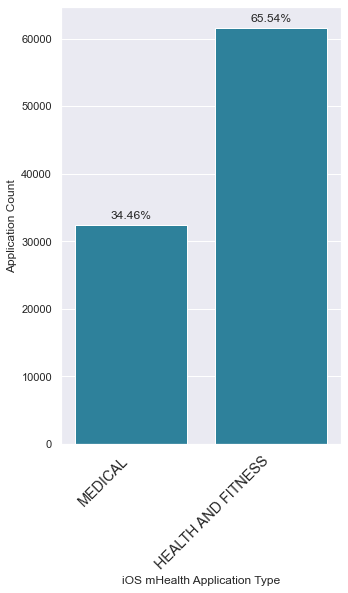

In [47]:
draw_count_plot_with_annot(df, 'App Type', 'iOS mHealth Application Type', 
                           'Application Count', fig_size=(5,6), annotCount=False)

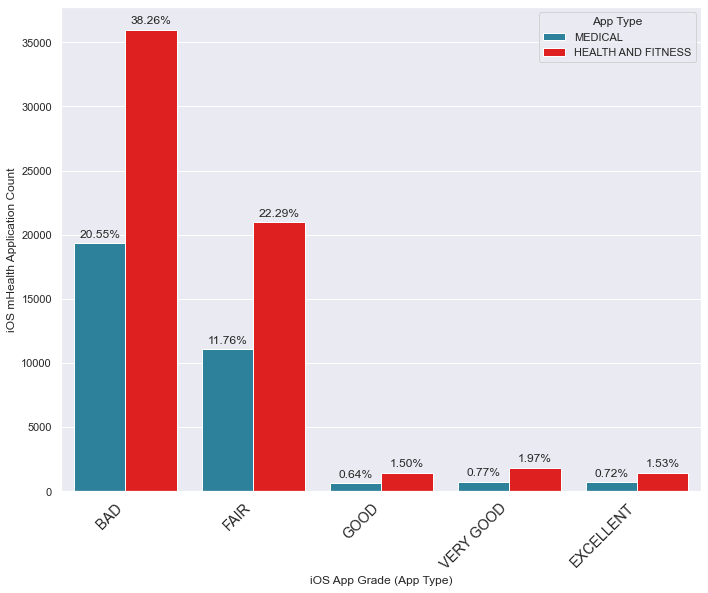

In [48]:
draw_count_plot_with_annot(df, 'App Grade', 'iOS App Grade (App Type)',
                           'iOS mHealth Application Count',hue= 'App Type', fig_size=(10,6), 
     order=app_grade_order, annotCount=False, palette=['#1C8BAD', 'red'])

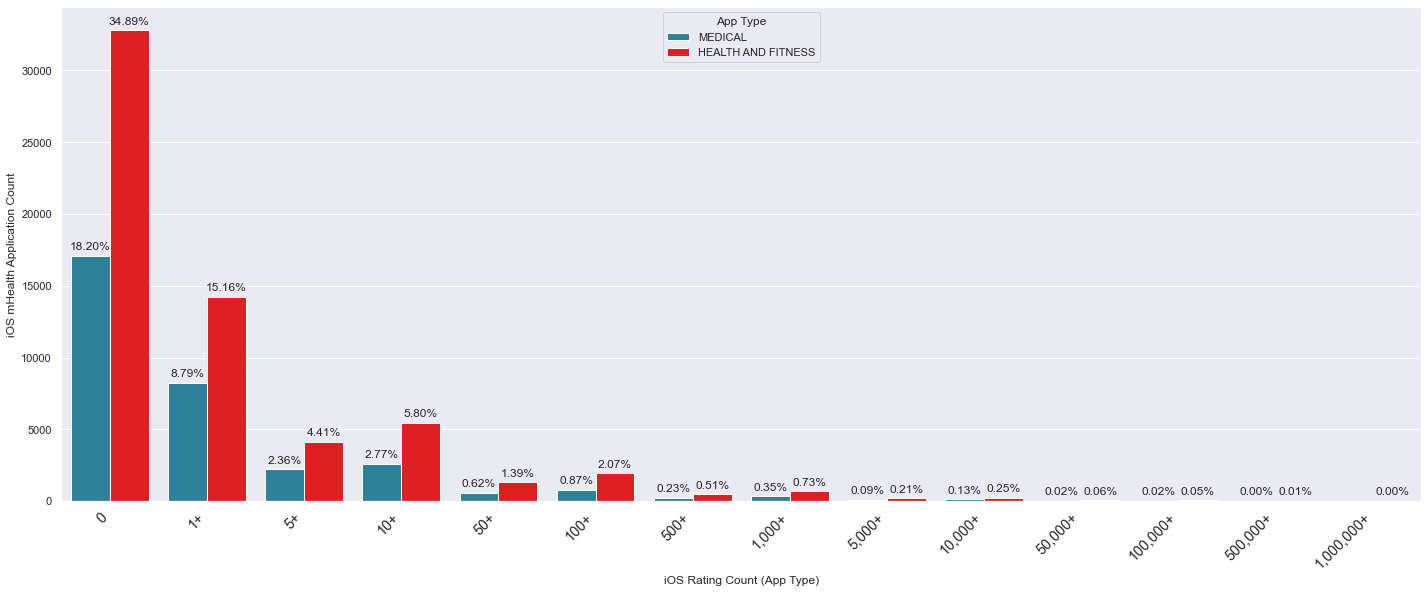

In [49]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'iOS Rating Count (App Type)',
                           'iOS mHealth Application Count',hue= 'App Type', fig_size=(20,6), 
     order=rating_count_range_order, annotCount=False, palette=['#1C8BAD', 'red'])

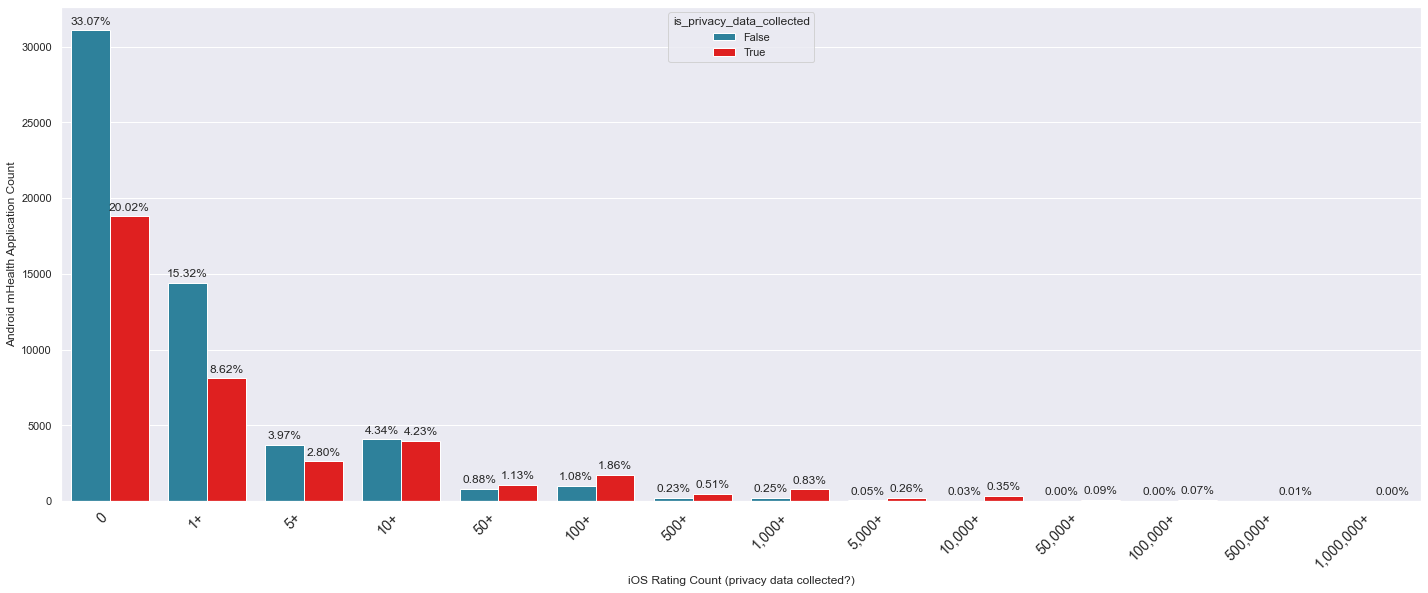

In [50]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'iOS Rating Count (privacy data collected?)',
                           'Android mHealth Application Count',hue= 'is_privacy_data_collected', fig_size=(20,6), 
     order=rating_count_range_order, annotCount=False, palette=['#1C8BAD', 'red'])

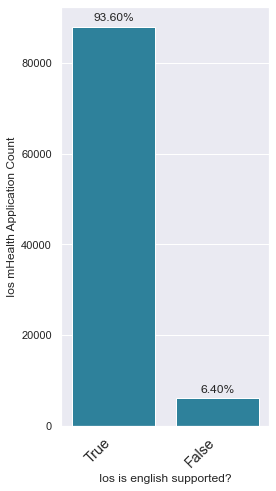

In [51]:
draw_count_plot_with_annot(df, 'is_english_supported', 'Ios is english supported?',
                           'Ios mHealth Application Count',fig_size=(4,5),
                           annotCount=False, order=[True, False])

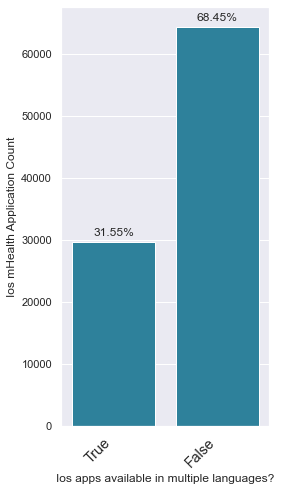

In [52]:
draw_count_plot_with_annot(df, 'is_available_in_multiple_langs', 'Ios apps available in multiple languages?',
                           'Ios mHealth Application Count',fig_size=(4,5),
                           annotCount=False, order=[True, False])

#### ASSOCIATION RULE MINING

In [53]:
def convert_consequent_to_str(consq):
    return str(consq).replace("frozenset({'", '').replace("})", '').replace("'", '')

In [54]:
def convert_antecedent_to_str(antecedent):
    antecedent = str(antecedent).replace("frozenset({'", '').replace("})", '').replace("'", '')
    return antecedent

In [55]:
def prepare_apriori_columns(df, column_list):
    apriori_df = list()
    for col in column_list:
        apriori_df.append(pd.get_dummies(df[col], prefix=col))
    apriori_df = pd.concat(apriori_df, axis=1)
    return apriori_df

def get_conditions_which_apps_are_most_likely_rated(min_support, min_threshold):
    apriori_df = prepare_apriori_columns(df,['Age Rating', 'InApp Purchase',
                                                       'App Grade', 'is_english_supported', 
                        'Download Type', 'is_available_in_multiple_langs', 'is_privacy_data_collected',
                                             'is_updated_this_year', 'Price Category'] )
    rules = apriori(apriori_df, min_support=min_support, use_colnames=True)
    association_rules_df = association_rules(rules, metric='confidence', min_threshold=min_threshold)
    association_rules_df["antecedent_len"] = association_rules_df["antecedents"].apply(lambda x: len(x))
    association_rules_df["consequents_len"] = association_rules_df["consequents"].apply(lambda x: len(x))
    association_rules_df['antecedents'] = association_rules_df['antecedents'].apply(convert_antecedent_to_str)
    association_rules_df['consequents'] = association_rules_df['consequents'].apply(convert_consequent_to_str)
    association_rules_df.sort_values(by=['confidence'], ascending=False, inplace=True)
    return association_rules_df[(association_rules_df['consequents_len']==1) & 
                                (association_rules_df['antecedent_len']>1)]

In [56]:
association_df = get_conditions_which_apps_are_most_likely_rated(0.5, 0.5)

In [57]:
def print_consequents_and_antecedents(df, consequent):
    filtered_df = df[df['consequents'].str.find(consequent) > -1]
    i = 1
    for index in filtered_df.index:
        if (i < 10):
            ants = filtered_df.at[index, 'antecedents']
            cons = filtered_df.at[index, 'consequents']
            support = filtered_df.at[index, 'support']
            conviction = filtered_df.at[index, 'conviction']
            confidence = filtered_df.at[index, 'confidence']
            print(f'{i}. {ants} => {cons} ({round(support,2), round(confidence,2), round(conviction,2)})')
            i = i + 1

In [58]:
print_consequents_and_antecedents(association_df,'Download Type')

1. App Grade_BAD, is_english_supported_True => Download Type_FREE ((0.5, 0.93, 1.08))
2. App Grade_BAD, InApp Purchase_False => Download Type_FREE ((0.51, 0.93, 1.07))
3. is_english_supported_True, Age Rating_4+ => Download Type_FREE ((0.54, 0.92, 0.96))
4. is_english_supported_True, InApp Purchase_False => Download Type_FREE ((0.74, 0.92, 0.9))
5. is_english_supported_True, is_available_in_multiple_langs_False => Download Type_FREE ((0.57, 0.91, 0.87))
6. InApp Purchase_False, is_available_in_multiple_langs_False => Download Type_FREE ((0.53, 0.91, 0.82))
7. is_english_supported_True, is_updated_this_year_False => Download Type_FREE ((0.61, 0.91, 0.81))
8. InApp Purchase_False, is_updated_this_year_False => Download Type_FREE ((0.57, 0.9, 0.77))
9. is_english_supported_True, InApp Purchase_False, is_updated_this_year_False => Download Type_FREE ((0.54, 0.9, 0.75))


In [59]:
print_consequents_and_antecedents(association_df,'App Grade')

1. InApp Purchase_False, Download Type_FREE => App Grade_BAD ((0.51, 0.65, 1.16))
2. InApp Purchase_False, is_english_supported_True => App Grade_BAD ((0.5, 0.63, 1.1))
3. is_english_supported_True, Download Type_FREE => App Grade_BAD ((0.5, 0.58, 0.98))


In [60]:
print_consequents_and_antecedents(association_df,'Age Rating')

1. is_english_supported_True, Download Type_FREE => Age Rating_4+ ((0.54, 0.63, 1.01))


In [61]:
print_consequents_and_antecedents(association_df,'is_updated_this_year')

1. InApp Purchase_False, is_english_supported_True => is_updated_this_year_False ((0.59, 0.74, 1.08))
2. is_english_supported_True, InApp Purchase_False, Download Type_FREE => is_updated_this_year_False ((0.54, 0.73, 1.03))
3. InApp Purchase_False, Download Type_FREE => is_updated_this_year_False ((0.57, 0.72, 1.01))
4. is_english_supported_True, Download Type_FREE => is_updated_this_year_False ((0.61, 0.71, 0.97))


In [62]:
print_consequents_and_antecedents(association_df,'is_available_in_multiple_langs')

1. InApp Purchase_False, Download Type_FREE => is_available_in_multiple_langs_False ((0.53, 0.68, 0.97))
2. InApp Purchase_False, is_english_supported_True => is_available_in_multiple_langs_False ((0.53, 0.66, 0.93))
3. is_english_supported_True, Download Type_FREE => is_available_in_multiple_langs_False ((0.57, 0.66, 0.92))


In [63]:
print_consequents_and_antecedents(association_df,'is_english_supported')

1. Download Type_FREE, Age Rating_4+ => is_english_supported_True ((0.54, 0.94, 1.06))
2. Download Type_FREE, is_updated_this_year_False => is_english_supported_True ((0.61, 0.94, 1.05))
3. InApp Purchase_False, is_updated_this_year_False => is_english_supported_True ((0.59, 0.94, 1.04))
4. is_updated_this_year_False, InApp Purchase_False, Download Type_FREE => is_english_supported_True ((0.54, 0.94, 1.01))
5. InApp Purchase_False, Download Type_FREE => is_english_supported_True ((0.74, 0.93, 0.92))
6. App Grade_BAD, InApp Purchase_False => is_english_supported_True ((0.5, 0.91, 0.75))
7. App Grade_BAD, Download Type_FREE => is_english_supported_True ((0.5, 0.91, 0.74))
8. Download Type_FREE, is_available_in_multiple_langs_False => is_english_supported_True ((0.57, 0.91, 0.67))
9. InApp Purchase_False, is_available_in_multiple_langs_False => is_english_supported_True ((0.53, 0.9, 0.66))


In [64]:
print_consequents_and_antecedents(association_df,'Price Category')

#### CLUSTERING

- Price
- Average Rating
- Rating count
- Number of versions

In [65]:
def get_age_integer(age_rating):
    return int(age_rating.replace('+',''))

In [66]:
df['age_rating_integer'] = df['Age Rating'].apply(get_age_integer)

In [67]:
def draw_elbow_graph(kmeans_df):
    wcss=[]
    for i in range(1,15):
        kmeans = KMeans(i)
        kmeans.fit(kmeans_df)
        wcss_iter = kmeans.inertia_
        wcss.append(wcss_iter)

    number_clusters = range(1,15)
    pyplot.subplot(2, 2, 1)
    pyplot.plot(number_clusters,wcss)
    pyplot.title('The Elbow title')
    pyplot.xlabel('Number of clusters')
    pyplot.ylabel('WCSS')
    fig = pyplot.gcf()
    fig.set_size_inches(24, 16)

In [68]:
def execute_kmeans(df, columns,n_cluster):
    standard_scaler = StandardScaler()
    kmeans_df = df[columns]
    kmeans_df_scaled = standard_scaler.fit_transform(kmeans_df)
    draw_elbow_graph(kmeans_df_scaled)
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(kmeans_df_scaled)
    labels = kmeans.predict(kmeans_df_scaled)
    centroids = kmeans.cluster_centers_
    kmeans_df_cluster = kmeans_df.copy()
    kmeans_df_cluster['cluster'] = labels
#     print(kmeans_df_cluster['cluster'].value_counts())
    if (len(columns) == 3):
        ax = pyplot.subplot(2, 2, 2, projection='3d')
        ax.scatter(kmeans_df_scaled[:,0], kmeans_df_scaled[:,1], kmeans_df_scaled[:,2] ,c=kmeans.labels_, 
                   cmap='rainbow',
               edgecolor='k', s=40, alpha = 0.5)
        ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
               kmeans.cluster_centers_[:,2], s = 300, c = 'r',
               marker='*', label = 'Centroid')
    elif (len(columns) == 4):
        ax = pyplot.subplot(2, 2, 2, projection='3d')
        ax.scatter(kmeans_df_scaled[:,0], kmeans_df_scaled[:,1], kmeans_df_scaled[:,2] , kmeans_df_scaled[:,3]
                   ,c=kmeans.labels_, 
                   cmap='rainbow',
               edgecolor='k', s=40, alpha = 0.5)
        ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
               kmeans.cluster_centers_[:,2], kmeans.cluster_centers_[:,3], s = 300, c = 'r',
               marker='*', label = 'Centroid')
    else:
        ax = pyplot.subplot(2, 2, 2)
        ax.scatter(kmeans_df_scaled[:, 0],kmeans_df_scaled[:, 1],
            c=kmeans.labels_,cmap='rainbow')
    
    fig = pyplot.gcf()
    fig.set_size_inches(20, 16)
    return kmeans_df_cluster

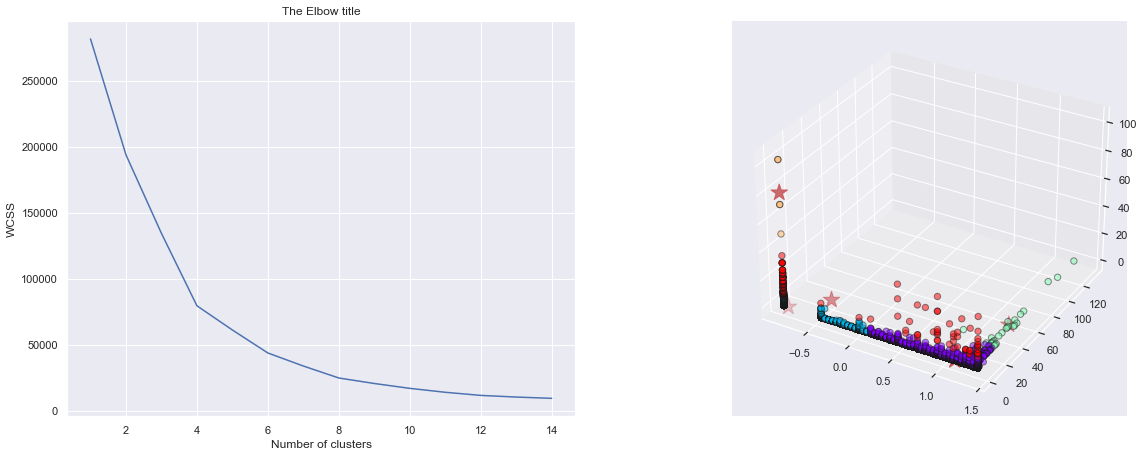

In [69]:
kmeans_df_cluster_df3 = execute_kmeans(df, ['Average Rating', 'Rating Count', 'Price'], 5)

In [70]:
kmeans_df_cluster_df3['cluster'].value_counts()

1    54443
0    39328
4      178
2       25
3        5
Name: cluster, dtype: int64

In [71]:
kmeans_df_cluster_df3.groupby(by='cluster').min()

,Average Rating,Rating Count,Price
cluster,,,
0,2.3,1,0.00
1,0.0,0,0.00
2,4.0,335900,0.00
3,0.0,0,499.99
4,0.0,0,74.99


In [72]:
kmeans_df_cluster_df3.groupby(by='cluster').max()

,Average Rating,Rating Count,Price
cluster,,,
0,5.0,323600,69.99
1,2.2,3200,69.99
2,4.9,1800000,0.00
3,0.0,0,999.99
4,5.0,6900,399.99


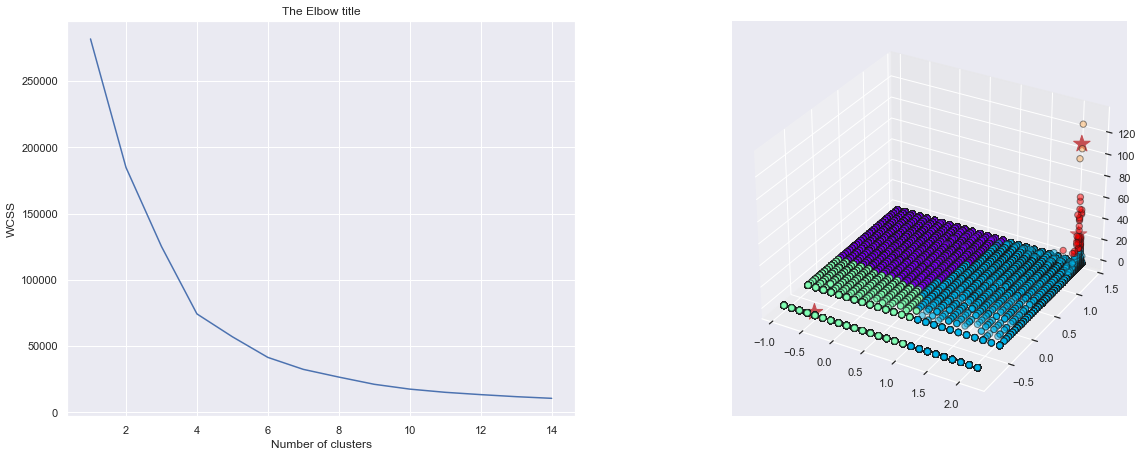

In [73]:
kmeans_df_cluster_df4 = execute_kmeans(df, ['Number of Versions', 'Average Rating', 'Rating Count'], 5)

In [74]:
kmeans_df_cluster_df4['cluster'].value_counts()

2    49361
0    27275
1    17303
4       37
3        3
Name: cluster, dtype: int64

In [75]:
kmeans_df_cluster_df4.groupby(by='cluster').min()

,Number of Versions,Average Rating,Rating Count
cluster,,,
0,1,2.2,1
1,13,0.0,0
2,1,0.0,0
3,25,4.7,1400000
4,25,4.0,222800


In [76]:
kmeans_df_cluster_df4.groupby(by='cluster').max()

,Number of Versions,Average Rating,Rating Count
cluster,,,
0,15,5.0,26700
1,25,5.0,213300
2,16,2.3,1500
3,25,4.8,1800000
4,25,4.9,899500


#### CLASSIFICATION MODEL

##### Rating count is a good variable to determine the average rating based on correlation

In [77]:
target_attributes = ['Price Category Ord', 'Rating Count Range Ord', 'Number of Versions', 'Age Rating Ord', 
                     'InApp Purchase Ord', 'is_english_supported Ord', 'is_available_in_multiple_langs Ord',
                     'Download Type Ord', 'App Type Ord', 'is_privacy_data_collected Ord', 'is_app_ever_updated Ord',
                     'is_updated_this_year Ord' ]

In [78]:
def create_ordinal_fields(df):
    age_rating_map = {'4+' : 3, '9+' : 2, '12+' : 1, '17+' : 0 }
    app_grading_map = {'EXCELLENT' : 4, 'VERY GOOD' : 3, 'GOOD' : 2, 'FAIR' : 1, 'BAD' : 0 }
    rating_count_map = {'0' : 0, '1+' : 1, '5+' : 2, '10+' : 3, '50+' : 4, '100+' : 5, '500+' : 6, '1,000+' : 7,
                       '5,000+' : 8, '10,000+' : 9, '50,000+' : 10, '100,000+' : 11, '500,000+' : 12, '1,000,000+': 13}
    price_map = {np.nan : 0, 'None' : 0, '0+' : 1, '1+' : 1, '5+' : 2, '10+' : 3, '50+' : 4, '100+' : 5, '500+' : 6}
    inapp_purchase_map = {True : 1, False : 0}
    service_type_map = {'PAID' : 1, 'FREE' : 0}
    app_type_map = {'MEDICAL' : 1, 'HEALTH AND FITNESS' : 0}
    english_supported_map = {True : 1, False : 0}
    available_in_multiple_langs_map = {True : 1, False : 0}
    privacy_data_collected_map = {True : 1, False : 0}
    app_ever_updated_map = {True : 1, False : 0}
    updated_this_year_map = {True : 1, False : 0}
    df['Age Rating Ord'] = df['Age Rating'].replace(age_rating_map)
    df['InApp Purchase Ord'] = df['InApp Purchase'].replace(inapp_purchase_map)
    df['is_english_supported Ord'] = df['is_english_supported'].replace(english_supported_map)
    df['is_available_in_multiple_langs Ord'] = df['is_available_in_multiple_langs'].replace(available_in_multiple_langs_map)
    df['is_privacy_data_collected Ord'] = df['is_privacy_data_collected'].replace(privacy_data_collected_map)
    df['is_app_ever_updated Ord'] = df['is_app_ever_updated'].replace(app_ever_updated_map)
    df['is_updated_this_year Ord'] = df['is_updated_this_year'].replace(updated_this_year_map)
    df['App Grade Ord'] = df['App Grade'].replace(app_grading_map)
    df['Download Type Ord'] = df['Download Type'].replace(service_type_map)
    df['Rating Count Range Ord'] = df['Rating Count Range'].replace(rating_count_map)
    df['App Type Ord'] = df['App Type'].replace(app_type_map)
    df['Price Category Ord'] = df['Price Category'].replace(price_map)
    return df


In [79]:
updated_df = create_ordinal_fields(df.copy())

In [80]:
def draw_heatmap(df):
    df_num = df[['Price Category Ord', 'Number of Versions', 'is_privacy_data_collected Ord',
                 'is_updated_this_year Ord', 'is_available_in_multiple_langs Ord', 'is_english_supported Ord',
                 'InApp Purchase Ord', 'is_app_ever_updated Ord',
                'Download Type Ord','Rating Count Range Ord', 'App Type Ord', 'Age Rating Ord', 'App Grade Ord']]
    ax = sbn.heatmap( df_num.corr(method='spearman'), cmap = 'rainbow', annot=True)
    fig = pyplot.gcf()
    fig.set_size_inches(18, 8)
    font = {'family': 'Times New Roman','color':  'black','weight': 'bold','size': 16}
    pyplot.xlabel('Correlation map for Ios dataset features', fontdict=font)

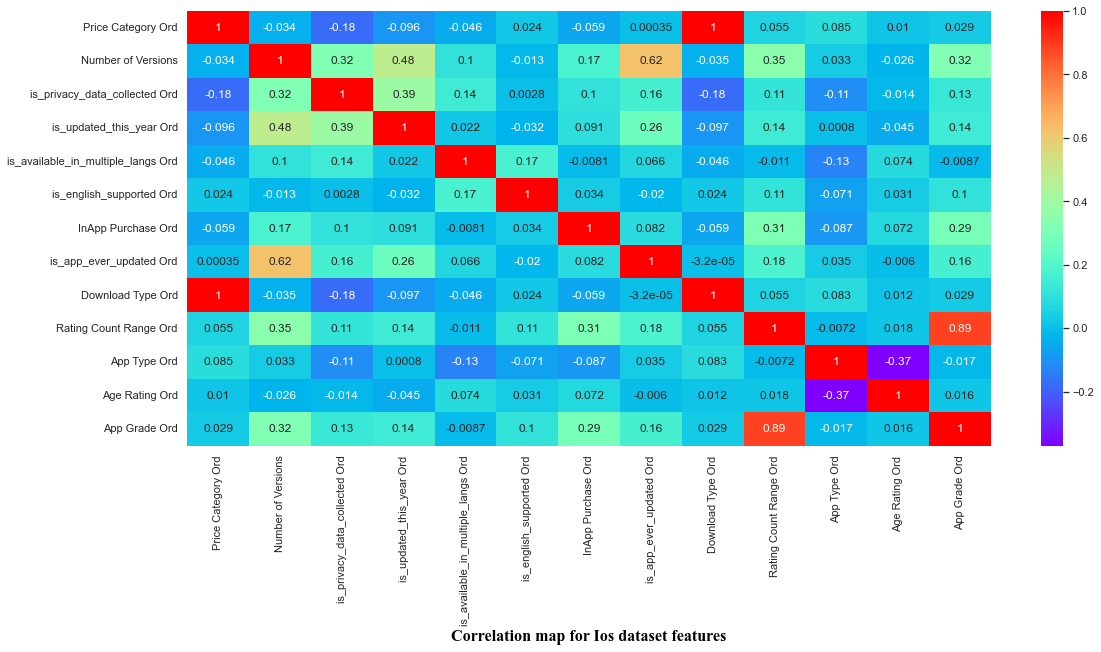

In [81]:
draw_heatmap(updated_df)

In [82]:
def get_top_features(no_of_features, X, Y):
    selector = SelectKBest(chi2, k="all") 
    selector.fit(X[target_attributes], Y)
    scores = (selector.scores_)
    argument_sort = list(np.argsort(scores))
    selected_attributes, selected_attribute_scores = [], []
    for i in range(len(target_attributes)-no_of_features,len(target_attributes)):
        value = argument_sort[i]
        selected_attributes.append(target_attributes[value])
        selected_attribute_scores.append(scores[value])
    return selected_attributes, selected_attribute_scores

In [83]:
selected_attributes, selected_attributes_score = get_top_features(7, 
                                            updated_df, 
                                             updated_df['App Grade Ord'])

In [84]:
selected_attributes_score

[153.48162461088143,
 388.99289488356226,
 1595.6396931723118,
 2288.491501741103,
 9267.104410419417,
 105384.22907204225,
 196545.3027506937]

In [85]:
selected_attributes

['is_available_in_multiple_langs Ord',
 'is_app_ever_updated Ord',
 'is_privacy_data_collected Ord',
 'is_updated_this_year Ord',
 'InApp Purchase Ord',
 'Number of Versions',
 'Rating Count Range Ord']

In [86]:
updated_df['App Grade'].value_counts()

BAD          55269
FAIR         32006
VERY GOOD     2573
EXCELLENT     2118
GOOD          2013
Name: App Grade, dtype: int64

Text(0.5, 0, 'SelectKBest for top 7 features (iOS)')

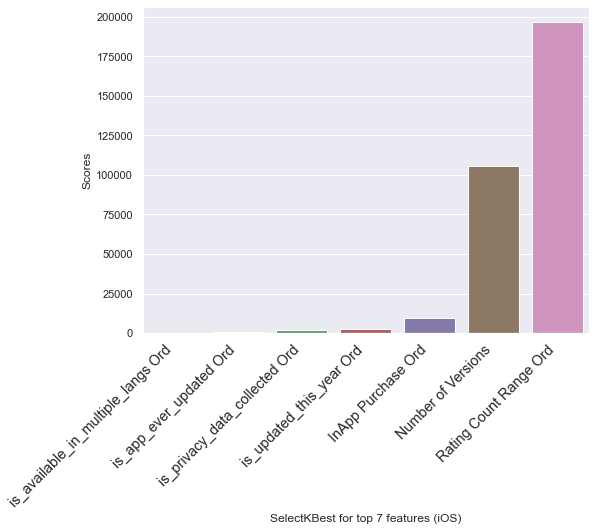

In [87]:
sbn.barplot(x=selected_attributes, y=selected_attributes_score)
set_plot_labels('Attributes', 'Scores', 'large')
fig = pyplot.gcf()
fig.set_size_inches(8, 6)
pyplot.xlabel('SelectKBest for top 7 features (iOS)')

In [88]:
filtered_attributes = ['Rating Count Range Ord', 'Number of Versions', 'is_privacy_data_collected Ord',
                     'InApp Purchase Ord', 'is_updated_this_year Ord']

In [89]:
updated_df['App Grade Ord'].value_counts()

0    55269
1    32006
3     2573
4     2118
2     2013
Name: App Grade Ord, dtype: int64

In [90]:
X_train, X_test, y_train, y_test = train_test_split(updated_df[filtered_attributes],
                                                    updated_df['App Grade Ord'], test_size=0.25, random_state=42)

In [91]:
y_train.value_counts()

0    41352
1    24095
3     1951
4     1555
2     1531
Name: App Grade Ord, dtype: int64

In [92]:
def oversample_train_data(X_train, y_train):
    oversampler = SMOTE()
    oversampled_df_X, oversampled_df_Y = oversampler.fit_resample(X_train, y_train)
    return oversampled_df_X, oversampled_df_Y

In [93]:
oversampled_df_X, oversampled_df_Y = oversample_train_data(X_train, y_train)

In [94]:
def evaluate_and_get_classification_report(clf, train_X, train_Y, test_X, test_Y):
    print(f'============ Model {type(clf)} ====================')
    fitted_model = clf.fit(train_X,train_Y)
    print('Training score for => ', fitted_model.score(train_X,train_Y))
    y_pred = fitted_model.predict(test_X)
    print('Validation accuracy for => ', fitted_model.score(test_X, test_Y))
    target_names = ['BAD','FAIR','GOOD', 'VERY GOOD', 'EXCELLENT']
    print('Classification Report Summary')
    print(classification_report(test_Y, y_pred, target_names=target_names))
    print(f'====================================================')

In [95]:
clfs = [DecisionTreeClassifier(), GaussianNB(), LogisticRegression(max_iter=1500), XGBClassifier()]

In [96]:
for clf in clfs:
    evaluate_and_get_classification_report(clf, oversampled_df_X[filtered_attributes], 
                                           oversampled_df_Y,X_test[filtered_attributes], y_test )

============ Model <class 'sklearn.tree._classes.DecisionTreeClassifier'> ====================
Training score for =>  0.9318291739214548
Validation accuracy for =>  0.9331772717599489
Classification Report Summary
              precision    recall  f1-score   support

         BAD       1.00      0.90      0.95     13917
        FAIR       0.86      0.99      0.92      7911
        GOOD       0.86      0.85      0.85       482
   VERY GOOD       0.80      0.89      0.85       622
   EXCELLENT       0.86      0.96      0.91       563

    accuracy                           0.93     23495
   macro avg       0.88      0.92      0.90     23495
weighted avg       0.94      0.93      0.93     23495

============ Model <class 'sklearn.naive_bayes.GaussianNB'> ====================
Training score for =>  0.8043238537434707
Validation accuracy for =>  0.7739944669078528
Classification Report Summary
              precision    recall  f1-score   support

         BAD       0.81      0.89      0.8